# Water quality prediction

The task here is to predict if the water is drinkable or not, considering its characteristics. The dataset used in this work is from Kaggle, and some of the parts of this notebook are defined using the contributions of Kaggle users. Note that some people pointed out the possibility that the dataset is not from the real-world (given some characteristics of some instances). However, it is still a good exercise to apply some data analysis and machine learning techniques. You can find this dataset [here](https://www.kaggle.com/adityakadiwal/water-potability).

In [1]:
# Imports.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as lines 

from skimage import io
from scipy.stats import skew, kurtosis

## Styles

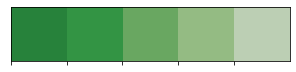

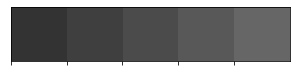

In [2]:
# Define color palettes.
greens = ['#27823b','#339444','#69a761','#94bb83','#bccfb4']
darks = ['#333333','#3f3f3f','#4b4b4b','#585858','#666666']
cmap_greens = sns.color_palette(greens)
cmap_darks = sns.color_palette(darks)
sns.set_palette(cmap_greens)

# Show the palettes.
sns.palplot(cmap_greens)
sns.palplot(cmap_darks)

In [3]:
# Set style for the figures.
sns.set_style('white')
plt.rcParams['font.family'] = 'monospace'

## Basic overview

In [4]:
# Read the dataset and show first rows.
file_path = "../Datasets/kaggle/water_potability.csv"
df = pd.read_csv(file_path)
print("Shape of the dataset: ", df.shape)

Shape of the dataset:  (3276, 10)


In [5]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Looks like we have some missing values, lets see more info about them.

## Missing values

In [7]:
# Get the missing values.
missing = df.isna().sum()
missing = missing.sort_values(ascending=False)
missing = missing[missing>0]
missing = pd.DataFrame({'Attribute': missing.index, 'Count': missing.values})

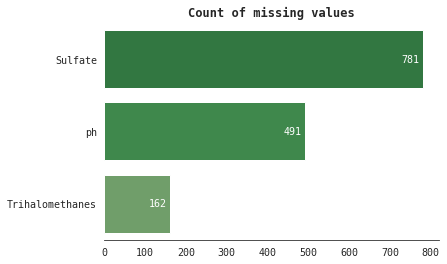

In [8]:
# Plot count of NaNs.
fig, ax = plt.subplots()
plt.title('Count of missing values', fontweight='bold')
ax = sns.barplot(data=missing, y='Attribute', x='Count')
ax.set_xlabel('')
ax.set_ylabel('')
ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(True) 

# Add annotation to the bars.
for i in range(0, len(missing)):
    ax.annotate(missing['Count'][i], 
                xy = (missing['Count'][i] - 30, i),
                va='center', ha='center', color='#ffff')

In [9]:
# Print number of instances of the dataset. 
print("Num instances before NaN drop: %d" % len(df))

Num instances before NaN drop: 3276


In [10]:
# Drop rows with NaN.
df = df.dropna()
df = df.reset_index(drop=True)
print("Num instances after NaN drop: %d" % len(df))

Num instances after NaN drop: 2011


In [11]:
# Show the new dataframe.
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
1,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
2,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
3,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
4,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0


## Analysing Class Distribution

In [12]:
# Lets get the counts of each class after we dropped the NaNs.
counts_class = df.Potability.value_counts()
counts_class = ({'Not Drinkable': counts_class[0], 'Drinkable': counts_class[1]})
print(counts_class)

{'Not Drinkable': 1200, 'Drinkable': 811}


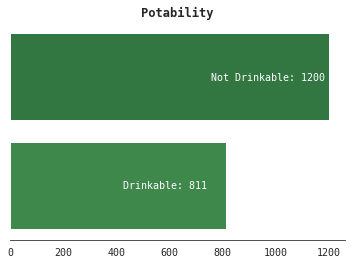

In [13]:
# Show them in a figure.
fig, ax = plt.subplots()
plt.title('Potability', fontweight='bold')
ax = sns.countplot(data=df, y='Potability', palette=cmap_greens)
plt.xlabel('')
plt.ylabel('')
plt.yticks([])
ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(True) 

for idx, key in enumerate(counts_class):
    ax.annotate(key + ": " + str(counts_class[key]), 
                xy = (counts_class[key] - 230, idx),
                va='center', ha='center', color='#ffff')

## Exploratory analysis

Let's see the histograms for these guys.

In [14]:
# Get all feature names and split the dataset df into each class.
feature_cols = [*df.columns.drop(labels='Potability')]
df_class_0 = df[df['Potability'] == 0].copy()
df_class_1 = df[df['Potability'] == 1].copy()

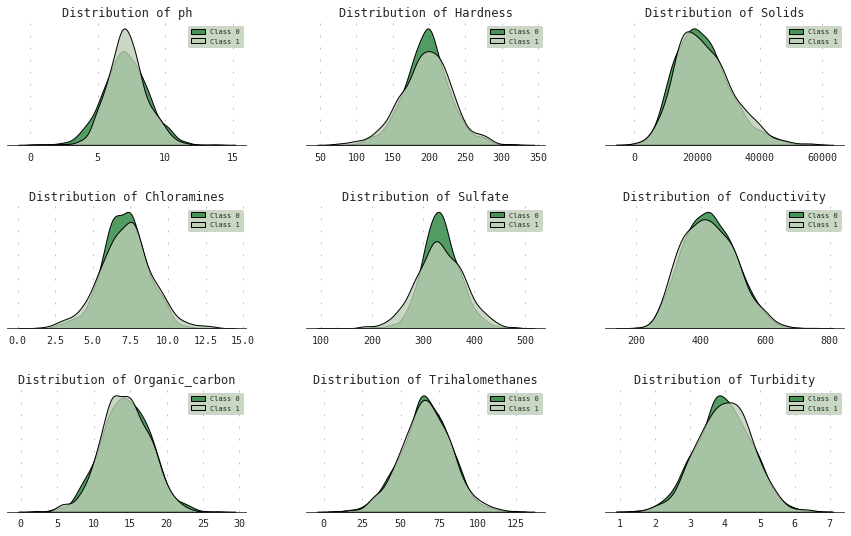

In [15]:
# Plot the things.
fig = plt.figure(figsize=(15,9))

for idx, feature in enumerate(feature_cols):
    plt.subplot(3,3,idx+1)
    plt.title(f"Distribution of {feature}")
    plt.grid(color='gray', axis='x', linestyle=':', 
             linewidth=1, alpha=0.5, zorder=0, dashes=(2,10))
    
    # Distribution for class 0
    sns.kdeplot(data=df_class_0, x=feature, shade=True, color=greens[0], 
                edgecolor='black', linewidth=1, alpha=0.8, label="Class 0"
    )
    
    # Distribution for class 1
    sns.kdeplot(data=df_class_1, x=feature, shade=True, color=greens[4], 
                edgecolor='black', linewidth=1, alpha=0.8, label="Class 1"
    )
    
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks([])

    plt.legend(facecolor=greens[4], fontsize=7)
    sns.despine(left=True)
    

fig.subplots_adjust(wspace=0.25,hspace=0.5)
plt.show()

Seems like ph, Hardness, Sulfate and Chloramines are the most relevant attributes to define if the water is potable or not. Lets analyse the correlation between attributes.

In [16]:
correlation = df.drop(columns='Potability').corr()
correlation

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
ph,1.000000,0.108948,-0.087615,-0.024768,0.010524,0.014128,0.028375,0.018278,-0.035849
Hardness,0.108948,1.000000,-0.053269,-0.022685,-0.108521,0.011731,0.013224,-0.015400,-0.034831
Solids,-0.087615,-0.053269,1.000000,-0.051789,-0.162769,-0.005198,-0.005484,-0.015668,0.019409
Chloramines,-0.024768,-0.022685,-0.051789,1.000000,0.006254,-0.028277,-0.023808,0.014990,0.013137
Sulfate,0.010524,-0.108521,-0.162769,0.006254,1.000000,-0.016192,0.026776,-0.023347,-0.009934
Conductivity,0.014128,0.011731,-0.005198,-0.028277,-0.016192,1.000000,0.015647,0.004888,0.012495
Organic_carbon,0.028375,0.013224,-0.005484,-0.023808,0.026776,0.015647,1.000000,-0.005667,-0.015428
Trihalomethanes,0.018278,-0.015400,-0.015668,0.014990,-0.023347,0.004888,-0.005667,1.000000,-0.020497
Turbidity,-0.035849,-0.034831,0.019409,0.013137,-0.009934,0.012495,-0.015428,-0.020497,1.000000


Since the table is not very attractive, a heatmap will allow to see things clearly.

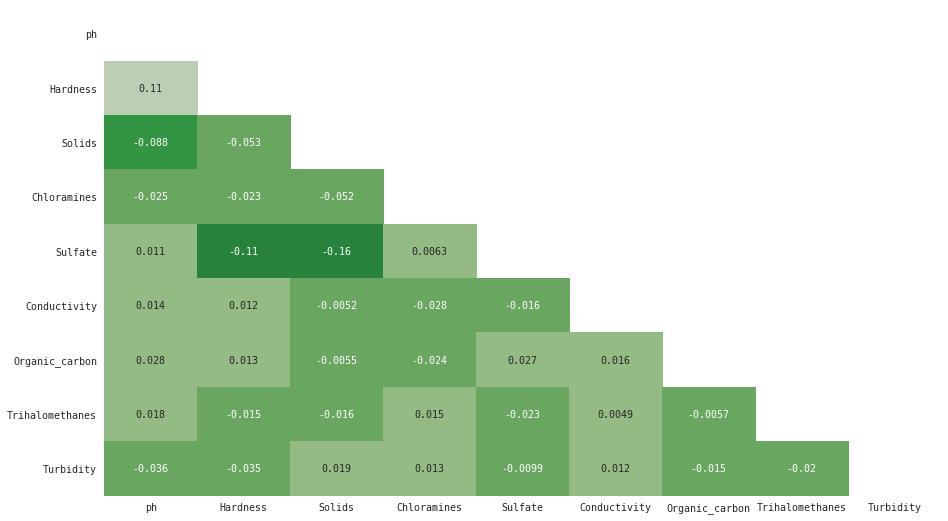

In [17]:
# Use a mask to have only the values of the lower 
# triangle of the correlation matrix.
mask = np.triu(np.ones_like(correlation, dtype=bool))

# Create heatmap for better visualisation.
fig = plt.figure(figsize=(15,9))

sns.heatmap(data=correlation, cbar_kws={'shrink': 0.82},
            annot=True, cmap=greens, cbar=False, mask=mask)

plt.show()

There is no strong evidence of multicolinearity, except for Sulfate related to Hardness and Solids. Let's see visualise these guys using a scatterplot.

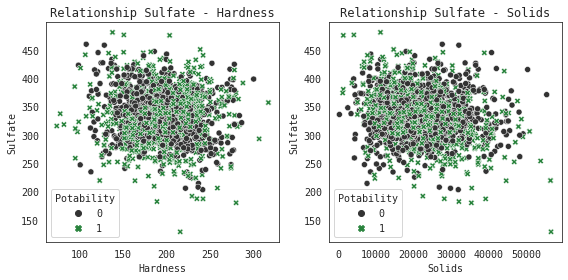

In [18]:
# Plot the things.
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].set_title("Relationship Sulfate - Hardness")
sns.scatterplot(ax=axes[0], data=df, x="Hardness", y="Sulfate", 
                hue="Potability", style="Potability", 
                palette=[cmap_darks[0], cmap_greens[0]])

axes[1].set_title("Relationship Sulfate - Solids")
sns.scatterplot(ax=axes[1], data=df, x="Solids", y="Sulfate", 
                hue="Potability", style="Potability", 
                palette=[cmap_darks[0], cmap_greens[0]])

fig.subplots_adjust(wspace=0.25,hspace=0.5)
fig.tight_layout()
plt.show()

It is possible to see that there is not much clarity regarding the way Sulfate varies as Hardness or Solids do. This is also aligned to the heatmap in which the correlations between the variables were very low. We can therefore assume that there is no multicolinearity between predictive variables.

## Initial Experiments

In [19]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

In [28]:
# Get feature dataset (X) and label dataset (y).
X = np.asarray(df.drop(columns='Potability'))
y = np.asarray(df['Potability'])

# Train/Test Split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [29]:
# Define and apply the pipeline. We use logistic regression here.
pipesteps = [('standardise', StandardScaler()), ('logit', LogisticRegression())]
pipe = Pipeline(pipesteps)

# Fit the model and get predictions.
pipe.fit(X_train, y_train)

Pipeline(steps=[('standardise', StandardScaler()),
                ('logit', LogisticRegression())])

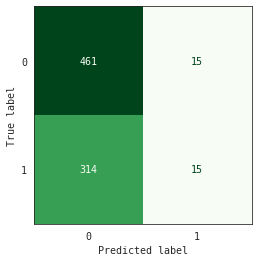

In [30]:
# Let's see the confusion matrix for the results.
plot_confusion_matrix(estimator=pipe, 
                      X=X_test, 
                      y_true=y_test, 
                      cmap=plt.get_cmap('Greens'),
                      colorbar=False)  
plt.show()

In [31]:
# Things doesn't look very good, now let's see the classification report.
target_names = ['Not Potable', 'Potable']
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Not Potable       0.59      0.97      0.74       476
     Potable       0.50      0.05      0.08       329

    accuracy                           0.59       805
   macro avg       0.55      0.51      0.41       805
weighted avg       0.56      0.59      0.47       805



We can see a very bad result for Recall for the Potable class. This is due to that the model is overfitting, tending to classify most of the instances as part of the Not Potable class. This is why it has a high Recall for that class, the model correctly classifies all instances of that class but then it has a lower Precision, probably having a lot of True Positives but also a high amount of False Positives (classes from Potable class that were classified as Not Potable).

Ok, so, let's see if we can improve this a little bit.

## Searching for a better classifier

I really like **Random Forests**. They are fast, effective, and can give interesting baseline results right from the start.

In [35]:
## RANDOM FOREST - DEFAULT HYPERPARAMETERS
from sklearn.ensemble import RandomForestClassifier

# Define and apply the pipeline. We use logistic regression here.
pipe = Pipeline([('standardise', StandardScaler()), 
                 ('forest', RandomForestClassifier())])

# Fit the model and get predictions.
pipe.fit(X_train, y_train)

# Classification report.
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Not Potable       0.68      0.87      0.76       476
     Potable       0.69      0.40      0.50       329

    accuracy                           0.68       805
   macro avg       0.68      0.64      0.63       805
weighted avg       0.68      0.68      0.66       805



This got A LOT better, only by using a "stronger" classifier without having to do hyperparameter search, ect. Let's try another method (since RF is a bagging algorithm, we will use boosting now): **Gradient Boosting**.

In [45]:
## GRADIENT BOOSTING - DEFAULT HYPERPARAMETERS
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier

# Define and apply the pipeline. We use logistic regression here.
pipe = Pipeline([('standardise', StandardScaler()), 
                 ('gboost', HistGradientBoostingClassifier())])

# Fit the model and get predictions.
pipe.fit(X_train, y_train)

# Classification report.
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

 Not Potable       0.68      0.77      0.72       476
     Potable       0.58      0.47      0.52       329

    accuracy                           0.65       805
   macro avg       0.63      0.62      0.62       805
weighted avg       0.64      0.65      0.64       805



Results are similar than those obtained with RF. In the future, we can try other things (such as grid/random/bayesian search) to improve the current results.